In [1]:
import pandas as pd

# Load the data
races = pd.read_csv("races.csv")
runs = pd.read_csv("runs.csv")

# Merge race and run data
df = runs.merge(races, on="race_id", how="left")

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Remove races without odds (not useful for simulation)
df = df.dropna(subset=['win_odds', 'place_odds'])

# Example: filter only the years of interest (1997 to 2005)
df = df[(df['date'].dt.year >= 1997) & (df['date'].dt.year <= 2005)]

# Reset index
df = df.reset_index(drop=True)

# Check shape and key columns
print(df.shape)
print(df[['race_id', 'date', 'horse_no', 'horse_id', 'draw', 'win_odds', 'place_odds', 'won']].head())


(75712, 73)
   race_id       date  horse_no  horse_id  draw  win_odds  place_odds  won
0        0 1997-06-02         1      3917     7       9.7         3.7  0.0
1        0 1997-06-02         2      2157    12      16.0         4.9  0.0
2        0 1997-06-02         3       858     8       3.5         1.5  0.0
3        0 1997-06-02         4      1853    13      39.0        11.0  0.0
4        0 1997-06-02         5      2796    14      50.0        14.0  0.0


### Feature Engineering
We scale numerical features and encode categorical variables. We also create time-based features (year, month).

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Numeric features
numeric_cols = ['draw', 'horse_rating', 'declared_weight', 'actual_weight', 'horse_age']
df[numeric_cols] = df[numeric_cols].fillna(-1)  # fill missing values with -1
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Categorical features
categorical_cols = ['horse_country', 'horse_type', 'horse_gear', 'trainer_id', 'jockey_id', 'venue', 'surface']
df[categorical_cols] = df[categorical_cols].fillna("unknown")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

# Temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Target
df['target'] = df['won'].astype(int)

# Final features (you can modify this later)
feature_cols = numeric_cols + categorical_cols + ['year', 'month']

# Check
print("Final features:", feature_cols)
print(df[feature_cols + ['target']].head())


Final features: ['draw', 'horse_rating', 'declared_weight', 'actual_weight', 'horse_age', 'horse_country', 'horse_type', 'horse_gear', 'trainer_id', 'jockey_id', 'venue', 'surface', 'year', 'month']
       draw  horse_rating  declared_weight  actual_weight  horse_age  \
0  0.032259     -0.090871        -1.355590       1.629262  -0.354169   
1  1.366014     -0.090871        -1.997144       1.629262  -0.354169   
2  0.299010     -0.090871        -0.361182       1.470768  -0.354169   
3  1.632765     -0.090871         0.216216       0.678295  -0.354169   
4  1.899516     -0.090871        -2.125454       1.312273  -0.354169   

   horse_country  horse_type  horse_gear  trainer_id  jockey_id  venue  \
0            1.0         3.0         0.0       111.0        2.0    1.0   
1           11.0         3.0         0.0       153.0       56.0    1.0   
2           11.0         3.0         0.0       129.0       17.0    1.0   
3           12.0         3.0         0.0        74.0       58.0    1.0  

### Train/Test Split
We split the dataset chronologically to avoid leakage and simulate future predictions.

In [3]:
# Features and target
X = df[feature_cols]
y = df['target']

# Division by year
X_train = X[df['year'] < 2005]
y_train = y[df['year'] < 2005]

X_test = X[df['year'] == 2005]
y_test = y[df['year'] == 2005]

print("Training size:", X_train.shape)
print("Test size:", X_test.shape)


Training size: (72579, 14)
Test size: (3133, 14)


### Train/Test Split
We split the dataset chronologically to avoid leakage and simulate future predictions.

In [5]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Creating the model
model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    verbose=-1
)

# Training without early stopping
model.fit(X_train, y_train)

# Previsions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Avaliation
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred_proba > 0.5))


AUC: 0.6466666666666667
              precision    recall  f1-score   support

           0       0.94      0.84      0.88      2883
           1       0.16      0.37      0.23       250

    accuracy                           0.80      3133
   macro avg       0.55      0.60      0.56      3133
weighted avg       0.88      0.80      0.83      3133



### Betting Simulation (Model-Based)
We simulate bets on horses with the highest predicted probabilities and calculate profit and ROI.

In [6]:
import numpy as np

# Add predicted probabilities to the original X_test
X_test_with_proba = X_test.copy()
X_test_with_proba['race_id'] = df.loc[X_test.index, 'race_id'].values
X_test_with_proba['horse_id'] = df.loc[X_test.index, 'horse_id'].values
X_test_with_proba['won'] = y_test.values
X_test_with_proba['win_odds'] = df.loc[X_test.index, 'win_odds'].values
X_test_with_proba['predicted_proba'] = y_pred_proba

# Select the horse with the highest predicted probability per race
top_preds = X_test_with_proba.sort_values(by='predicted_proba', ascending=False)
top_preds = top_preds.groupby('race_id').head(1).reset_index(drop=True)

# Bet $100 per race
top_preds['bet'] = 100
top_preds['payout'] = np.where(top_preds['won'] == 1, top_preds['win_odds'] * top_preds['bet'], 0)
top_preds['profit'] = top_preds['payout'] - top_preds['bet']

# Corrected statistics
total_races = len(top_preds)
total_profit = top_preds['profit'].sum()
roi = total_profit / (total_races * top_preds['bet'].iloc[0])  # Real ROI per dollar invested

print(f"Total races bet on: {total_races}")
print(f"Total profit: ${total_profit:.2f}")
print(f"Average ROI per dollar bet: {roi:.4f} ({roi*100:.2f}%)")


Total races bet on: 249
Total profit: $2250.00
Average ROI per dollar bet: 0.0904 (9.04%)


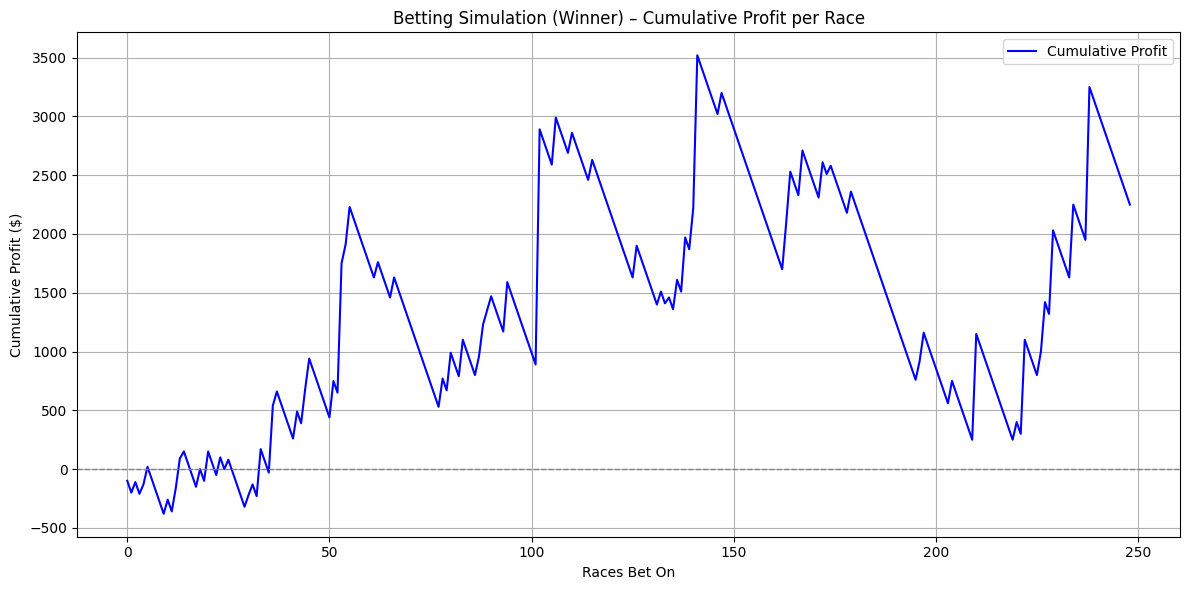

In [7]:
import matplotlib.pyplot as plt

# Check if 'profit' column exists in the DataFrame
if 'profit' not in top_preds.columns:
    print("Error: 'top_preds' does not yet contain the simulation data.")
else:
    # Calculate cumulative profit
    top_preds['cumulative_profit'] = top_preds['profit'].cumsum()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(top_preds['cumulative_profit'], label='Cumulative Profit', color='blue')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Betting Simulation (Winner) – Cumulative Profit per Race")
    plt.xlabel("Races Bet On")
    plt.ylabel("Cumulative Profit ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Betting Simulation (Model-Based)
We save the data into a csv file for futher analyze

In [8]:
import pandas as pd
import numpy as np

bet_value = 100  # bet amount per race

# Prepare dataset with LightGBM model information
X_test_with_proba = X_test.copy()
X_test_with_proba['race_id'] = df.loc[X_test.index, 'race_id'].values
X_test_with_proba['horse_id'] = df.loc[X_test.index, 'horse_id'].values
X_test_with_proba['won'] = y_test.values
X_test_with_proba['win_odds'] = df.loc[X_test.index, 'win_odds'].values
X_test_with_proba['predicted_proba'] = y_pred_proba

# Select the horse with the highest predicted probability per race
top_preds = X_test_with_proba.sort_values(by='predicted_proba', ascending=False)
top_preds = top_preds.groupby('race_id').head(1).reset_index(drop=True)

# Simulate bets with the defined value
top_preds['bet'] = bet_value
top_preds['payout'] = np.where(top_preds['won'] == 1, top_preds['win_odds'] * bet_value, 0)
top_preds['profit'] = top_preds['payout'] - bet_value
top_preds['cumulative_profit'] = top_preds['profit'].cumsum()

# Export to CSV
output_path = "lightgbm_bets.csv"
top_preds.to_csv(output_path, index=False)

print(f"LightGBM model bets saved to: {output_path}")


LightGBM model bets saved to: lightgbm_bets.csv


### Data Loading and Merging
Checking the columns in the csv file.

In [9]:
# Load csv
df_lgbm = pd.read_csv("lightgbm_bets.csv")

# Verify columns
print("CSV colums:")
print(df_lgbm.columns.tolist())
print(df_lgbm.head(3))


CSV colums:
['draw', 'horse_rating', 'declared_weight', 'actual_weight', 'horse_age', 'horse_country', 'horse_type', 'horse_gear', 'trainer_id', 'jockey_id', 'venue', 'surface', 'year', 'month', 'race_id', 'horse_id', 'won', 'win_odds', 'predicted_proba', 'bet', 'payout', 'profit', 'cumulative_profit']
       draw  horse_rating  declared_weight  actual_weight  horse_age  \
0 -1.301496      3.517974         1.114391       0.519801  -0.354169   
1 -0.501243      1.262446         1.964450       1.153779  -1.562425   
2 -1.568247     -0.632197        -0.040405       0.678295  -1.562425   

   horse_country  horse_type  horse_gear  trainer_id  jockey_id  ...  month  \
0            8.0         3.0        74.0       111.0       90.0  ...      1   
1            1.0         3.0        26.0         7.0       90.0  ...      1   
2            1.0         3.0       154.0       111.0       63.0  ...      2   

   race_id  horse_id  won  win_odds  predicted_proba  bet  payout  profit  \
0     5914   

### Model based strategy perfomance metrics
We calculate with more detail how the experiment would perform.

In [10]:
def analyze_betting_performance(df_bets, model_name="Model"):
    required_cols = {'bet', 'profit', 'payout', 'won'}
    missing = required_cols - set(df_bets.columns)
    if missing:
        raise ValueError(f"The CSV is missing the following columns: {missing}")

    total_bets = len(df_bets)
    total_staked = df_bets['bet'].sum()
    total_profit = df_bets['profit'].sum()
    total_payout = df_bets['payout'].sum()

    num_wins = df_bets[df_bets['won'] == 1].shape[0]
    win_rate = num_wins / total_bets if total_bets > 0 else 0

    roi_total = total_profit / total_staked if total_staked > 0 else 0
    roi_per_bet = df_bets['profit'].mean()
    std_profit = df_bets['profit'].std()

    positive_bets = (df_bets['profit'] > 0).sum()
    percent_profitable = positive_bets / total_bets if total_bets > 0 else 0

    # Drawdown
    cum_profit = df_bets['profit'].cumsum()
    running_max = cum_profit.cummax()
    drawdown = running_max - cum_profit
    max_drawdown = drawdown.max()

    print(f" Performance Analysis – {model_name}")
    print("=" * 50)
    print(f"Total bets: {total_bets}")
    print(f"Total staked: ${total_staked:.2f}")
    print(f"Total payout: ${total_payout:.2f}")
    print(f"Net profit: ${total_profit:.2f}")
    print(f"Win rate: {win_rate * 100:.2f}% ({num_wins}/{total_bets})")
    print(f"Total ROI: {roi_total * 100:.2f}%")
    print(f"Average profit per bet: ${roi_per_bet:.2f}")
    print(f"Standard deviation of profits: ${std_profit:.2f}")
    print(f"% of profitable bets: {percent_profitable * 100:.2f}%")
    print(f"Maximum drawdown: ${max_drawdown:.2f}")
    print("=" * 50)

    return {
        "total_bets": total_bets,
        "total_staked": total_staked,
        "total_profit": total_profit,
        "roi_total": roi_total,
        "roi_per_bet": roi_per_bet,
        "win_rate": win_rate,
        "std_profit": std_profit,
        "percent_profitable": percent_profitable,
        "max_drawdown": max_drawdown
    }


In [11]:
performance_summary = analyze_betting_performance(df_lgbm, model_name="Model based strategy")

 Performance Analysis – Model based strategy
Total bets: 249
Total staked: $24900.00
Total payout: $27150.00
Net profit: $2250.00
Win rate: 24.90% (62/249)
Total ROI: 9.04%
Average profit per bet: $9.04
Standard deviation of profits: $256.45
% of profitable bets: 24.90%
Maximum drawdown: $3270.00


### Model based strategy vs Betting on favorites
We compare the model based strategy versus betting on the horse with the lowest win odds (market favorite).


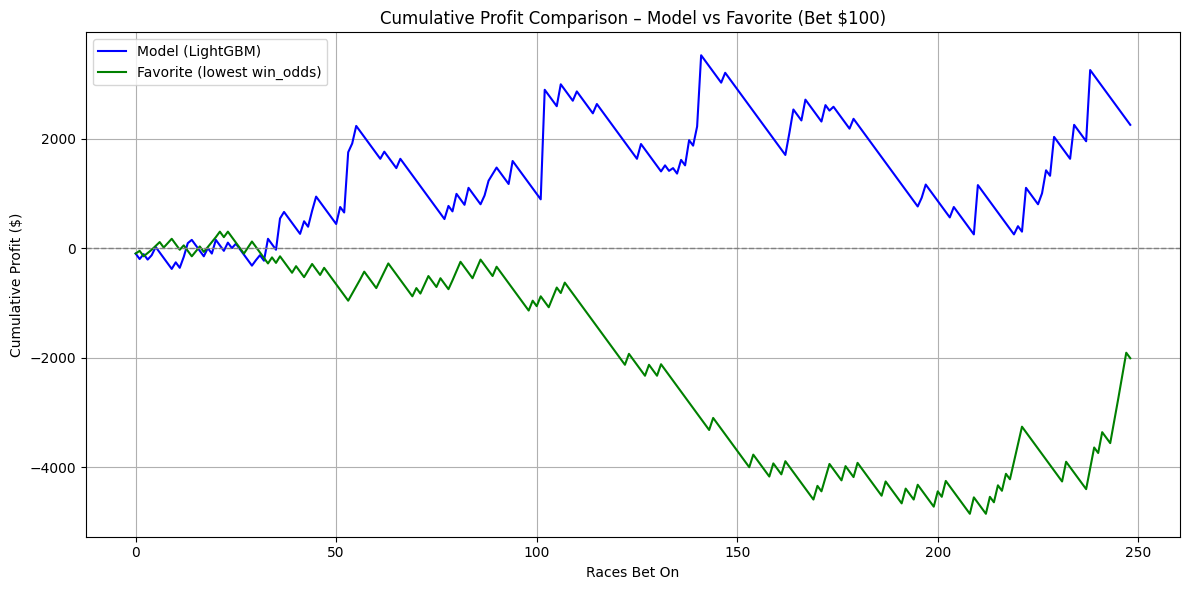

[Model] Total profit: $2250.00 | ROI: 9.04%
[Favorite] Total profit: $-2010.00 | ROI: -8.07%


In [12]:
# Select the horse with the lowest win_odds per race (favorite)
df_test = df.loc[X_test.index]
favorites = df_test.sort_values(by='win_odds', ascending=True).groupby('race_id').head(1).reset_index(drop=True)

bet_value = 100  # bet amount per race

# Simulate betting on the favorite (lowest win_odds)
favorites['bet'] = bet_value
favorites['payout'] = np.where(favorites['won'] == 1, favorites['win_odds'] * favorites['bet'], 0)
favorites['profit'] = favorites['payout'] - favorites['bet']
favorites['cumulative_profit'] = favorites['profit'].cumsum()

# Recalculate cumulative profit for the model predictions, if needed
top_preds['cumulative_profit'] = top_preds['profit'].cumsum()

# Plot comparison between model and favorite
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(top_preds['cumulative_profit'].values, label='Model (LightGBM)', color='blue')
plt.plot(favorites['cumulative_profit'].values, label='Favorite (lowest win_odds)', color='green')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f"Cumulative Profit Comparison – Model vs Favorite (Bet ${bet_value})")
plt.xlabel("Races Bet On")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics
model_profit = top_preds['profit'].sum()
model_roi = model_profit / (len(top_preds) * bet_value)

fav_profit = favorites['profit'].sum()
fav_roi = fav_profit / (len(favorites) * bet_value)

print(f"[Model] Total profit: ${model_profit:.2f} | ROI: {model_roi * 100:.2f}%")
print(f"[Favorite] Total profit: ${fav_profit:.2f} | ROI: {fav_roi * 100:.2f}%")


### Interpretation and improvement ideas
As we can see the model made better bets comparing to betting always on the favourite. 
Now we add thresholds of trust, filtering out bets with lower probability of success.

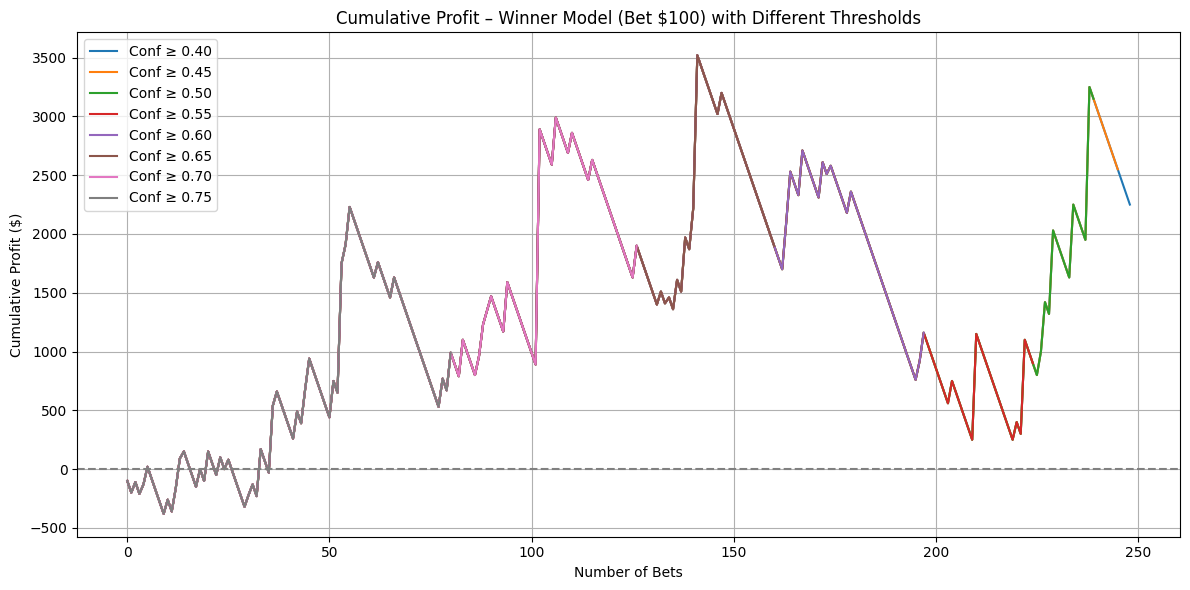

   threshold  num_bets  total_profit       roi
0       0.40       249        2250.0  0.090361
1       0.45       246        2550.0  0.103659
2       0.50       240        3150.0  0.131250
3       0.55       225         900.0  0.040000
4       0.60       198        1160.0  0.058586
5       0.65       161        1900.0  0.118012
6       0.70       127        1900.0  0.149606
7       0.75        81         990.0  0.122222


In [13]:
thresholds = [0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75]
bet_value = 100  # bet amount per race

# Prepare base with predicted probability per race
winner_preds = X_test.copy()
winner_preds['race_id'] = df.loc[X_test.index, 'race_id'].values
winner_preds['horse_id'] = df.loc[X_test.index, 'horse_id'].values
winner_preds['won'] = y_test.values
winner_preds['win_odds'] = df.loc[X_test.index, 'win_odds'].values
winner_preds['predicted_proba'] = y_pred_proba

# Select top-1 horse per race
top1_preds = winner_preds.sort_values(by='predicted_proba', ascending=False)
top1_preds = top1_preds.groupby('race_id').head(1).reset_index(drop=True)

# Evaluate different thresholds
results = []

plt.figure(figsize=(12, 6))

for thresh in thresholds:
    filtered = top1_preds[top1_preds['predicted_proba'] >= thresh].copy()
    filtered['bet'] = bet_value
    filtered['payout'] = np.where(filtered['won'] == 1, filtered['win_odds'] * bet_value, 0)
    filtered['profit'] = filtered['payout'] - filtered['bet']
    filtered['cumulative_profit'] = filtered['profit'].cumsum()

    total_bets = len(filtered)
    total_profit = filtered['profit'].sum()
    roi = total_profit / (total_bets * bet_value) if total_bets > 0 else 0

    results.append({
        'threshold': thresh,
        'num_bets': total_bets,
        'total_profit': total_profit,
        'roi': roi
    })

    # Plot cumulative profit
    plt.plot(filtered['cumulative_profit'].values, label=f'Conf ≥ {thresh:.2f}')

# Final plot
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"Cumulative Profit – Winner Model (Bet ${bet_value}) with Different Thresholds")
plt.xlabel("Number of Bets")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display results in table
results_df = pd.DataFrame(results)
print(results_df[['threshold', 'num_bets', 'total_profit', 'roi']])


### Interpretation 
Based in our research having a 0.7 threshold would improve the ROI. Let's find out more about it.

In [14]:
def analyze_betting_performance(df_bets, model_name="Model"):
    required_cols = {'bet', 'profit', 'payout', 'won'}
    missing = required_cols - set(df_bets.columns)
    if missing:
        raise ValueError(f"The CSV is missing the following columns: {missing}")

    total_bets = len(df_bets)
    total_staked = df_bets['bet'].sum()
    total_profit = df_bets['profit'].sum()
    total_payout = df_bets['payout'].sum()

    num_wins = df_bets[df_bets['won'] == 1].shape[0]
    win_rate = num_wins / total_bets if total_bets > 0 else 0

    roi_total = total_profit / total_staked if total_staked > 0 else 0
    roi_per_bet = df_bets['profit'].mean()
    std_profit = df_bets['profit'].std()

    positive_bets = (df_bets['profit'] > 0).sum()
    percent_profitable = positive_bets / total_bets if total_bets > 0 else 0

    cum_profit = df_bets['profit'].cumsum()
    running_max = cum_profit.cummax()
    drawdown = running_max - cum_profit
    max_drawdown = drawdown.max()

    print(f"Performance Analysis – {model_name}")
    print("=" * 50)
    print(f"Total bets: {total_bets}")
    print(f"Total staked: ${total_staked:.2f}")
    print(f"Total payout: ${total_payout:.2f}")
    print(f"Net profit: ${total_profit:.2f}")
    print(f"Win rate: {win_rate * 100:.2f}% ({num_wins}/{total_bets})")
    print(f"Total ROI: {roi_total * 100:.2f}%")
    print(f"Average profit per bet: ${roi_per_bet:.2f}")
    print(f"Profit standard deviation: ${std_profit:.2f}")
    print(f"% of profitable bets: {percent_profitable * 100:.2f}%")
    print(f"Maximum drawdown: ${max_drawdown:.2f}")
    print("=" * 50)


In [15]:
bet_value = 100

# Filtering out bets with trust >= 0.70
filtered_070 = top1_preds[top1_preds['predicted_proba'] >= 0.70].copy()
filtered_070['bet'] = bet_value
filtered_070['payout'] = np.where(filtered_070['won'] == 1, filtered_070['win_odds'] * bet_value, 0)
filtered_070['profit'] = filtered_070['payout'] - filtered_070['bet']

# Analisar desempenho detalhado
analyze_betting_performance(filtered_070, model_name="Model based strategy with trust ≥ 0.70")


Performance Analysis – Model based strategy with trust ≥ 0.70
Total bets: 127
Total staked: $12700.00
Total payout: $14600.00
Net profit: $1900.00
Win rate: 29.92% (38/127)
Total ROI: 14.96%
Average profit per bet: $14.96
Profit standard deviation: $254.88
% of profitable bets: 29.92%
Maximum drawdown: $1700.00


### Interpretation
This model version filtered almost half of the bets, with less payout value but improved in percentage of profit bets and so in total ROI. 

### Train/Test Split for beting in the placed positions
We split the dataset as done before but this time our target is placed positions, that's the ones we will consider to make the simulation bets.

In [16]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Create target variable `placed` (Top-3 finish)
df['placed'] = df['result'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Separate features and new target
X_placed = df[feature_cols]
y_placed = df['placed']

X_train_placed = X_placed[df['year'] < 2005]
y_train_placed = y_placed[df['year'] < 2005]

X_test_placed = X_placed[df['year'] == 2005]
y_test_placed = y_placed[df['year'] == 2005]

# Train model to predict placement
model_placed = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    scale_pos_weight=(y_train_placed == 0).sum() / (y_train_placed == 1).sum(),
    random_state=42,
    verbose=-1
)

model_placed.fit(X_train_placed, y_train_placed)

# Predict placement probabilities
y_pred_proba_placed = model_placed.predict_proba(X_test_placed)[:, 1]

# Evaluate
print("AUC (placed):", roc_auc_score(y_test_placed, y_pred_proba_placed))
print(classification_report(y_test_placed, y_pred_proba_placed > 0.5))


AUC (placed): 0.6527608057263982
              precision    recall  f1-score   support

           0       0.83      0.67      0.74      2386
           1       0.34      0.55      0.42       747

    accuracy                           0.64      3133
   macro avg       0.58      0.61      0.58      3133
weighted avg       0.71      0.64      0.66      3133



### Place Betting Simulation
We test the alternative strategy: betting on horses to place in the top 3.

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_80112\3276078577.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_test_placed_top = X_test_placed_top.groupby('race_id').apply(


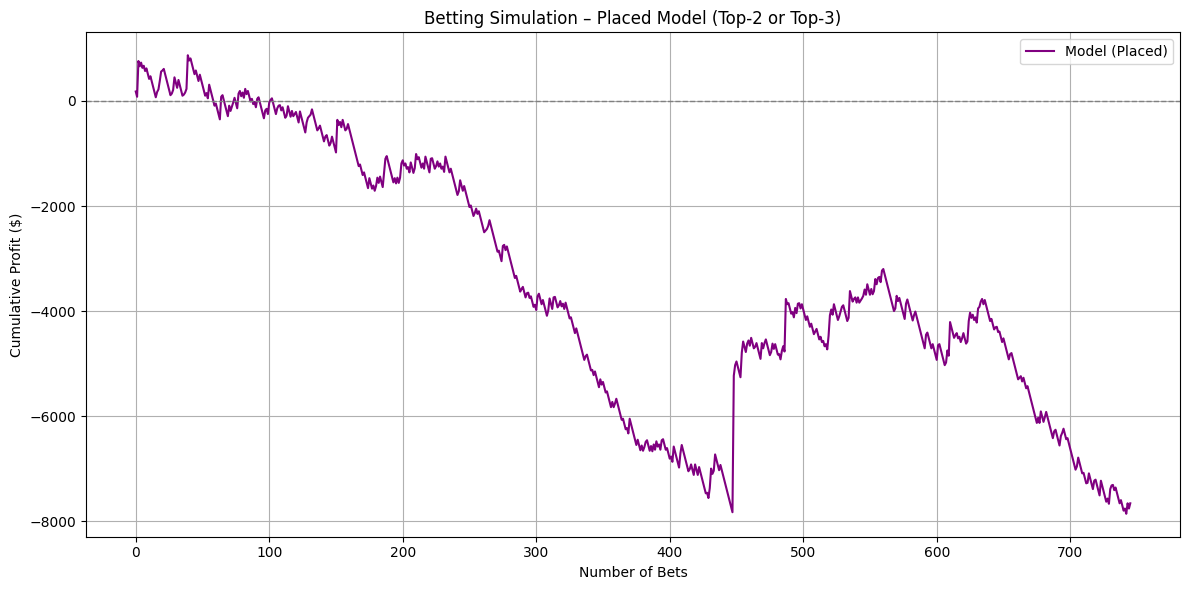

Bets placed: 746
Total profit: $-7660.00
Average ROI per bet: -1026.81%


In [17]:
# Prepare test data for placed model
X_test_placed_with_info = X_test_placed.copy()
X_test_placed_with_info['race_id'] = df.loc[X_test_placed.index, 'race_id'].values
X_test_placed_with_info['horse_id'] = df.loc[X_test_placed.index, 'horse_id'].values
X_test_placed_with_info['placed'] = y_test_placed.values
X_test_placed_with_info['place_odds'] = df.loc[X_test_placed.index, 'place_odds'].values
X_test_placed_with_info['predicted_proba'] = y_pred_proba_placed

# Count number of horses per race
horse_counts = X_test_placed_with_info['race_id'].value_counts().to_dict()
X_test_placed_with_info['num_horses'] = X_test_placed_with_info['race_id'].map(horse_counts)

# Choose top 2 or 3 horses per race based on number of participants
def top_n(row):
    return 2 if row['num_horses'] < 7 else 3

X_test_placed_with_info['top_n'] = X_test_placed_with_info.apply(top_n, axis=1)

# Sort by predicted probability and take up to top-3 per race
X_test_placed_sorted = X_test_placed_with_info.sort_values(by='predicted_proba', ascending=False)
X_test_placed_top = X_test_placed_sorted.groupby('race_id').head(3)

# Keep only the correct number of top-n per race
X_test_placed_top = X_test_placed_top.groupby('race_id').apply(
    lambda x: x.head(x['top_n'].iloc[0])
).reset_index(drop=True)

# Simulate bets with 100 units per bet
X_test_placed_top['bet'] = 100
X_test_placed_top['payout'] = np.where(
    X_test_placed_top['placed'] == 1,
    X_test_placed_top['place_odds'] * X_test_placed_top['bet'],
    0
)
X_test_placed_top['profit'] = X_test_placed_top['payout'] - X_test_placed_top['bet']
X_test_placed_top['cumulative_profit'] = X_test_placed_top['profit'].cumsum()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(X_test_placed_top['cumulative_profit'], label='Model (Placed)', color='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Betting Simulation – Placed Model (Top-2 or Top-3)")
plt.xlabel("Number of Bets")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistics
total_bets = len(X_test_placed_top)
total_profit = X_test_placed_top['profit'].sum()
roi = total_profit / total_bets

print(f"Bets placed: {total_bets}")
print(f"Total profit: ${total_profit:.2f}")
print(f"Average ROI per bet: {roi * 100:.2f}%")


### Interpretation 
Poor results so we move on. Now let's see if other models would perfom better compared to our lightgbm model based strategy.

### Train/Test Split
We train the model again with Random Forest, XGBoost and logistic Regression

In [18]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Class balancing
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
rf_proba = rf_model.predict_proba(X_test)[:, 1]
print("RandomForest AUC:", roc_auc_score(y_test, rf_proba))

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
print("XGBoost AUC:", roc_auc_score(y_test, xgb_proba))

# Logistic Regression
log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
log_model.fit(X_train, y_train)
log_proba = log_model.predict_proba(X_test)[:, 1]
print("LogisticRegression AUC:", roc_auc_score(y_test, log_proba))


RandomForest AUC: 0.6476795005202913


C:\Users\Utilizador\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.6508380159556018
LogisticRegression AUC: 0.6012403746097814


C:\Users\Utilizador\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### LightGBM Model vs other models
We simulate how which model would perform. 

In [19]:
def simulate_winner_strategy(probas, label="Model", confidence_threshold=0.0):
    preds = X_test.copy()
    preds['race_id'] = df.loc[X_test.index, 'race_id'].values
    preds['won'] = y_test.values
    preds['win_odds'] = df.loc[X_test.index, 'win_odds'].values
    preds['predicted_proba'] = probas

    # Select top-1 horse per race
    top1 = preds.sort_values(by='predicted_proba', ascending=False)
    top1 = top1.groupby('race_id').head(1).reset_index(drop=True)

    # Apply confidence threshold filter
    top1 = top1[top1['predicted_proba'] >= confidence_threshold].copy()

    # Calculate profit
    top1['payout'] = np.where(top1['won'] == 1, top1['win_odds'], 0)
    top1['profit'] = top1['payout'] - 1
    top1['cumulative_profit'] = top1['profit'].cumsum()
    top1['model'] = label

    return top1


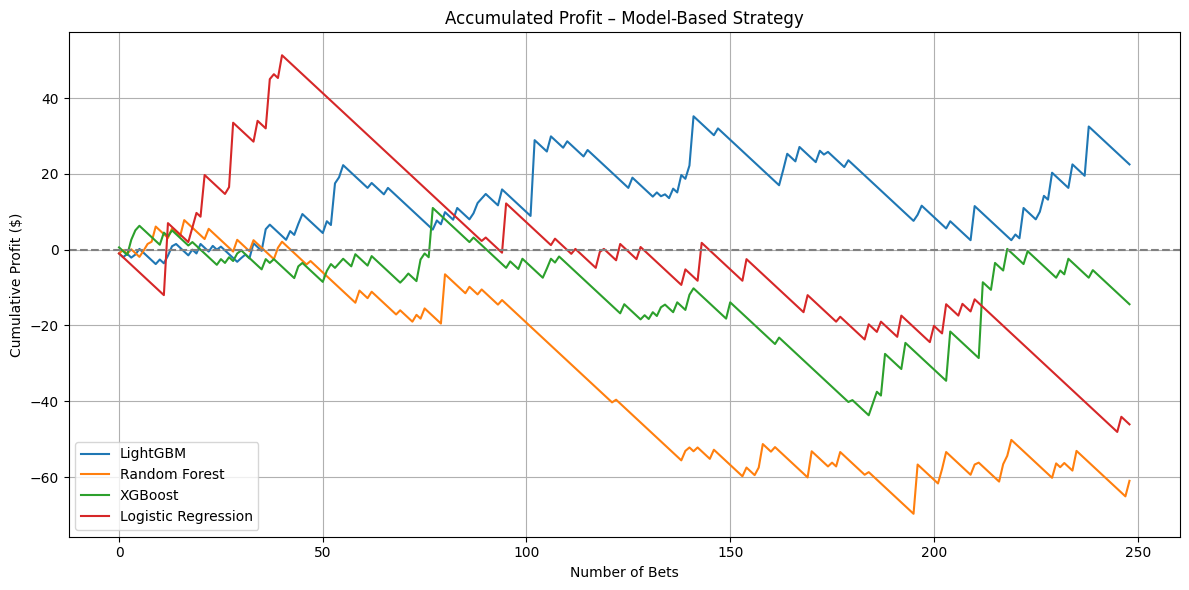

                Model  Bets  Profit       ROI
0            LightGBM   249    22.5  0.090361
1        RandomForest   249   -61.0 -0.244980
2             XGBoost   249   -14.4 -0.057831
3  LogisticRegression   249   -46.1 -0.185141


In [20]:
# simulate_winner_strategy(...)

# Results for plot and summary table
rf_results = simulate_winner_strategy(rf_proba, label="RandomForest")
xgb_results = simulate_winner_strategy(xgb_proba, label="XGBoost")
log_results = simulate_winner_strategy(log_proba, label="LogisticRegression")
lgb_results = simulate_winner_strategy(y_pred_proba, label="LightGBM")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(lgb_results['cumulative_profit'].values, label='LightGBM')
plt.plot(rf_results['cumulative_profit'].values, label='Random Forest')
plt.plot(xgb_results['cumulative_profit'].values, label='XGBoost')
plt.plot(log_results['cumulative_profit'].values, label='Logistic Regression')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Accumulated Profit – Model-Based Strategy")
plt.xlabel("Number of Bets")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary table
summary = pd.DataFrame([
    {"Model": "LightGBM", "Bets": len(lgb_results), "Profit": lgb_results['profit'].sum(), "ROI": lgb_results['profit'].mean()},
    {"Model": "RandomForest", "Bets": len(rf_results), "Profit": rf_results['profit'].sum(), "ROI": rf_results['profit'].mean()},
    {"Model": "XGBoost", "Bets": len(xgb_results), "Profit": xgb_results['profit'].sum(), "ROI": xgb_results['profit'].mean()},
    {"Model": "LogisticRegression", "Bets": len(log_results), "Profit": log_results['profit'].sum(), "ROI": log_results['profit'].mean()}
])

print(summary)


### Interpretation
The results are clear. LightGBM is the one for the task. Later investigation can be made, like tuning the parameters of other models but we take this as a starting point.